In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from colorama import Fore, Back, Style
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import os
import numpy as np
import datetime as dt
import time
import warnings
import talib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
package_dir = os.path.dirname(os.path.abspath('FICHIER DU 09 BOOST SAVE'))
#LeChemin = '/'+package_dir+'/20191211 BACKTEST/'
LeChemin = ''
list_dir = os.listdir(LeChemin+'DL_2019-12-06/.')
s=-1
symbol = 'AMZN'

In [3]:
LaBase = pd.read_csv(LeChemin+'LaBase_10.csv')
try:
    LaBAse = LaBase.drop(['Unnamed: 0'],axis=1)
except :
    pass
LaBase.index = pd.to_datetime(LaBase['Date'],format='%Y-%m-%d')
LaBase = LaBase.drop(['Date'],axis=1)
LaBase = LaBase.drop(['Close'],axis=1)
LaBase['Close'] = LaBase['Adj Close']
LaBase = LaBase.drop(['Adj Close'],axis=1)

In [4]:
NEW_LIST = []
TIME_LIST = []
for pikunichihouahoua in range(0,len(str(list_dir).split(','))):
    if str(list_dir).split(',')[pikunichihouahoua].split(',')[0].split('.')[1].split("'")[0]=='yaml':
        NEW_LIST.append(str(list_dir).split(',')[pikunichihouahoua].split(',')[0].split('.')[0].split("'")[1].split('_')[1])
NEW_LIST = sorted(set(NEW_LIST))

TIME_LIST = sorted(set(LaBase.index.strftime('%Y-%m-%d')))

In [5]:

df = LaBase[LaBase['Symbol'] == symbol]
df = df.drop(['Symbol'],axis=1)

In [7]:
%%time
print('Preparing data...')
df['Momentum']  = df['Volume'] * (df['Open'] - df['Close'])
df['Avg_price'] = (df['Low'] + df['High'])/2
df['Range']     = df['High'] - df['Low']
df['Ohlc_price'] = (df['Low'] + df['High'] + df['Open'] + df['Close'])/4
df['Oc_diff']    = df['Open'] - df['Close']
rsi = talib.RSI(df['Close'],timeperiod=14)
stoc_slowk, stoc_slowd = talib.STOCH(df['High'],df['Low'],df['Close'])
upper, middle, lower =  talib.BBANDS(df['Close'], timeperiod=9, nbdevup=2, nbdevdn=2,matype=0)
sma5 = talib.SMA(df['Close'],timeperiod=5)
sma8 = talib.SMA(df['Close'],timeperiod=8)
sma10 = talib.SMA(df['Close'],timeperiod=10)
sma12 = talib.SMA(df['Close'],timeperiod=12)
sma15 = talib.SMA(df['Close'],timeperiod=15)
sma30 = talib.SMA(df['Close'],timeperiod=30)
sma35 = talib.SMA(df['Close'],timeperiod=35)
sma40 = talib.SMA(df['Close'],timeperiod=40)
sma45 = talib.SMA(df['Close'],timeperiod=45)
sma50 = talib.SMA(df['Close'],timeperiod=50)
atr = talib.ATR(df['High'],df['Low'],df['Close'],timeperiod=10)
delta5_8 = sma5 - sma8
delta8_10 = sma8 - sma10
delta10_12 = sma10 - sma12
delta12_15 = sma12 - sma15
delta15_30 = sma15 - sma30
delta30_35 = sma30 - sma35
delta35_40 = sma35 - sma40
delta40_45 = sma40 - sma45
delta45_50 = sma45 - sma50
bbdelta = upper - middle
price_bolup = df['Close'] - lower
price_bolow = df['Close'] - upper
Ema = talib.EMA(df['Close'],timeperiod=20)
KC_High = Ema + 2*atr
KC_Low = Ema - 2*atr
aroondown, aroonup = talib.AROON(df['High'], df['Low'], timeperiod=9)
aroon = aroonup - aroondown #(aroonup-aroondown)/abs((aroonup-aroondown))
rsi30_list = []
rsi70_list = []
for i in range(0,df.shape[0]):
    rsi70_list.append(70 - rsi[i])
    rsi30_list.append(rsi[i] - 30)
    #except:
        #   rsi70_list.append(0)
        #  rs30_list.append(0)
varop_spy = df['Open'] - df['Close']
varhl_spy = df['High'] - df['Low']
df['Varop_Spy'] = varop_spy
df['Varhl_spy'] = varhl_spy
df['RSI'] = rsi
df['70 - RSI'] = np.array(rsi70_list)
df['RSI - 30'] = np.array(rsi30_list)
df['BBD_Delta_Up'] = bbdelta
df['delta5_8'] = delta5_8
df['delta8_10'] = delta8_10
df['delta10_12'] = delta10_12
df['delta12_15'] = delta12_15
df['delta15_30'] = delta15_30
df['delta30_35'] = delta30_35
df['delta35_40'] = delta35_40
df['delta40_45'] = delta40_45
df['delta45_50'] = delta45_50
df['Stoc_Slowk'] = stoc_slowk
df['Stoc_Slowd'] = stoc_slowd
df['KC_High'] = KC_High
df['KC_Low'] = KC_Low
df['upper'] = upper
df['lower'] = lower
df['var_bollup_kchigh'] = upper-KC_High
df['var_bolllow_kclow'] = lower-KC_Low
df['Aroon Up'] = aroonup
df['Aroon Down'] = aroondown
df['Delta Aroon'] = aroon
up = []
down = []
df['Volume'] = df['Volume'].shift(s) - df['Volume']
df['Target'] = df['Close'] - df['Close'].shift(s)
df = df.drop((['Close','High','Open','Low','upper','lower','KC_High','KC_Low','Avg_price','Ohlc_price']),axis=1)
df.rename(columns=lambda x: x.replace('Adj Close', 'Close'), inplace=True)
df = df.dropna()
df.head()


'''
df = df[['High','Low','Open','Volume','Close','Varop_Spy','Varhl_spy','RSI','70 - RSI','RSI - 30',\
'BBD_Delta_Up','delta5_8','delta8_10','delta10_12','delta12_15','delta15_30','delta30_35','delta35_40',\
'delta40_45','delta45_50','Stoc_Slowk','Stoc_Slowd','KC_High','KC_Low','upper','lower','var_bollup_kchigh',\
'var_bolllow_kclow','Aroon Up','Aroon Down','Delta Aroon','Close.S']]
'''


Preparing data...
CPU times: user 93.5 ms, sys: 3.15 ms, total: 96.7 ms
Wall time: 103 ms


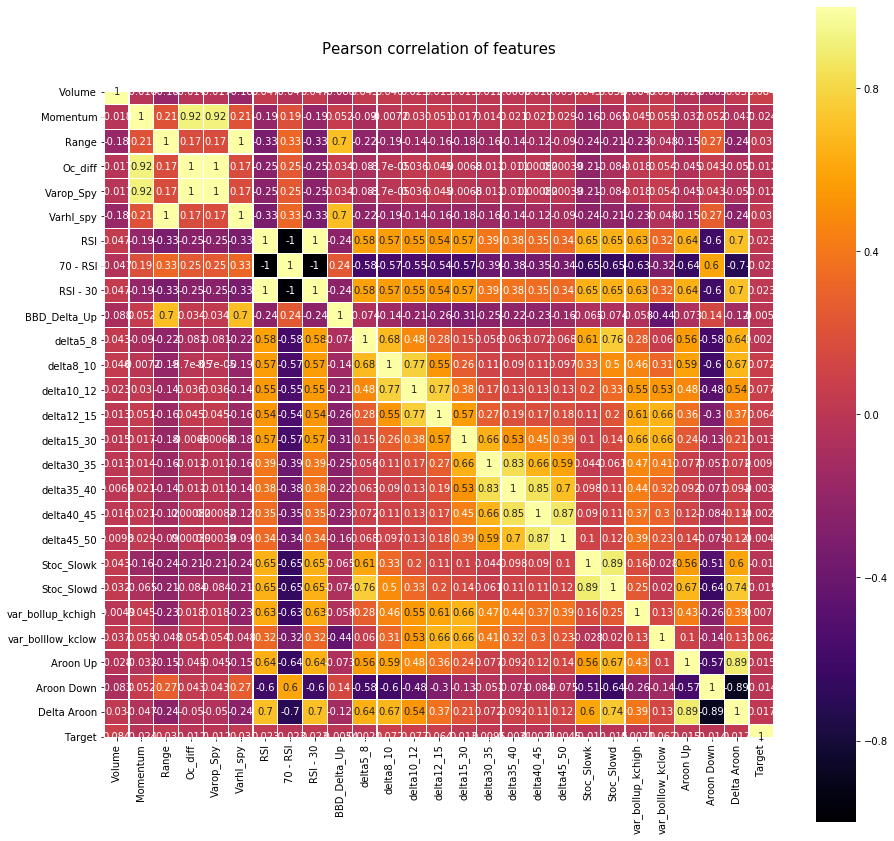

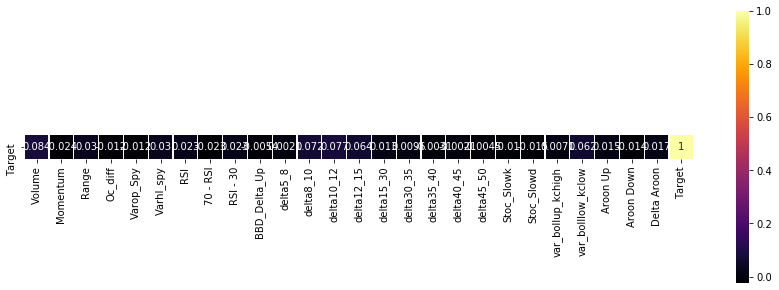

In [8]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'Target'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

In [9]:
%%time

print(Fore.YELLOW,'ON GENERE LES BOOST',Style.RESET_ALL)

seed = 770
np.random.seed(seed)
X = df.copy()
y = X.iloc[:,-1]
Xtrain = X.iloc[:-100,:-1]
Xtest = X.iloc[-100:-1,:-1]
ytrain = y.iloc[:-100]
ytest = y.iloc[-100:-1]

 ON GENERE LES BOOST 
CPU times: user 1.78 ms, sys: 271 µs, total: 2.05 ms
Wall time: 1.82 ms


In [10]:
%%time
# A parameter grid for XGBoost
params = {'min_child_weight':[1,10], 'gamma':[i/10.0 for i in range(1,11)],  'subsample':[i/10.0 for i in range(1,10)],
'colsample_bytree':[i/10.0 for i in range(1,11)], 'max_depth': [1,2,3,4,6,8,10]}

# Initialize XGB and GridSearch
xgbo = XGBRegressor(nthread=-1,objective='reg:squarederror') 

grid = GridSearchCV(xgbo, params)
grid.fit(Xtrain, ytrain)

CPU times: user 1h 6min 23s, sys: 7.13 s, total: 1h 6min 30s
Wall time: 1h 6min 36s


In [11]:
ytrain.head()

Date
2016-02-18    -9.900024
2016-02-19   -24.599976
2016-02-22     6.559998
2016-02-23    -1.099976
2016-02-24    -1.110046
Name: Target, dtype: float64

In [12]:
# Print the r2 score
print(r2_score(df['Target'].iloc[-100:-1], grid.best_estimator_.predict(Xtest)))

-0.01579864667977593


In [13]:
# Save the file
y_pred = grid.best_estimator_.predict(Xtest)

pred = grid.best_estimator_.predict((X.iloc[:,:-1]))

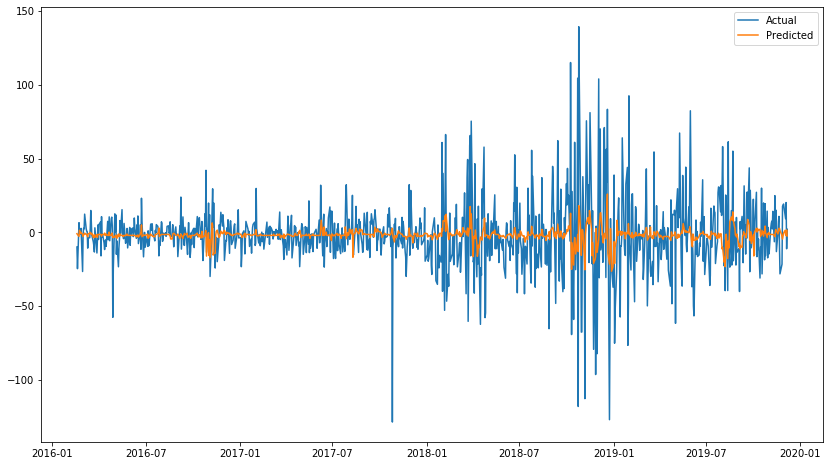

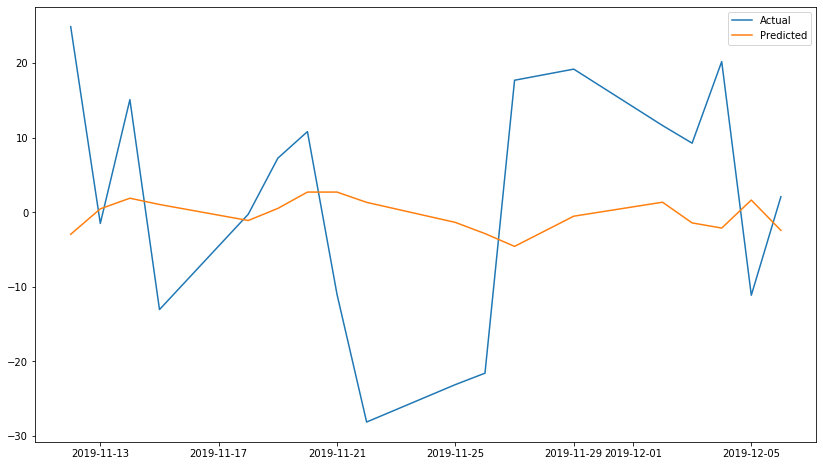

In [14]:
df['Pred'] = pred
df['%'] = (df['Target']-df['Pred'])*100/df['Target']
df.to_csv(LeChemin+'TEST_BOOST/'+symbol+'.csv')

plt.figure(figsize=(14,8))
plt.plot(df['Target'][:-2],label='Actual')
plt.plot(df['Pred'][:-2],label='Predicted')
plt.legend()

plt.figure(figsize=(14,8))
plt.plot(df['Target'][-20:-2],label='Actual')
plt.plot(df['Pred'][-20:-2],label='Predicted')
plt.legend()

In [24]:
Xvalid = df.iloc[-2:,:-3]

(grid.best_estimator_.predict(Xvalid)-df['Target'][-2:])*100/df['Target'][-2]

Date
2019-12-09    -85.098752
2019-12-10    106.461657
Name: Target, dtype: float64

In [25]:
Xvalid

,Volume,Momentum,Range,Oc_diff,Varop_Spy,Varhl_spy,RSI,70 - RSI,RSI - 30,BBD_Delta_Up,...,delta35_40,delta40_45,delta45_50,Stoc_Slowk,Stoc_Slowd,var_bollup_kchigh,var_bolllow_kclow,Aroon Up,Aroon Down,Delta Aroon
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-09,71500.0,2.809280e+06,21.280029,1.150024,1.150024,21.280029,44.948083,25.051917,14.948083,50.332749,...,0.743639,5.331498,3.534798,12.545243,13.395900,8.866437,8.227608,33.333333,77.777778,-44.444444
2019-12-10,-416700.0,2.059228e+07,15.670044,8.190063,8.190063,15.670044,42.418564,27.581436,12.418564,51.924672,...,-0.653003,5.255441,3.614353,14.950745,13.125305,8.453857,0.896531,22.222222,100.000000,-77.777778


In [27]:
df['Target'][-2:],grid.best_estimator_.predict(Xvalid)

(Date
 2019-12-09    10.300049
 2019-12-10    -9.510010
 Name: Target, dtype: float64, array([1.5348358, 1.4555929], dtype=float32))

In [16]:
print(r2_score(ytrain, grid.best_estimator_.predict(Xtrain)))

0.1318871173733297


In [17]:
model = xgb.XGBRegressor(n_estimators=200000, learning_rate=0.1, gamma=1, subsample=1, colsample_bytree=1, max_depth=100,objective='reg:squarederror')

model.fit( Xtrain, ytrain, early_stopping_rounds=150, eval_set=[(Xtest, ytest)], verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None,
       n_estimators=200000, n_jobs=1, nthread=None,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Feature ranking:
0. delta15_30 14 (0.091889)
1. BBD_Delta_Up 9 (0.088687)
2. delta10_12 12 (0.072351)
3. delta45_50 18 (0.065823)
4. var_bollup_kchigh 21 (0.064509)
5. delta35_40 16 (0.060829)
6. Range 2 (0.045906)
7. var_bolllow_kclow 22 (0.045335)
8. Volume 0 (0.044312)
9. Momentum 1 (0.042987)
10. Oc_diff 3 (0.041078)
11. delta40_45 17 (0.037999)
12. Aroon Down 24 (0.036934)
13. Aroon Up 23 (0.034794)
14. RSI 6 (0.034625)
15. delta30_35 15 (0.031633)
16. delta5_8 10 (0.031290)
17. delta12_15 13 (0.031078)
18. Stoc_Slowd 20 (0.029375)
19. delta8_10 11 (0.026912)
20. Stoc_Slowk 19 (0.023547)
21. Delta Aroon 25 (0.018105)
22. Varop_Spy 4 (0.000000)
23. Varhl_spy 5 (0.000000)
24. 70 - RSI 7 (0.000000)
25. RSI - 30 8 (0.000000)


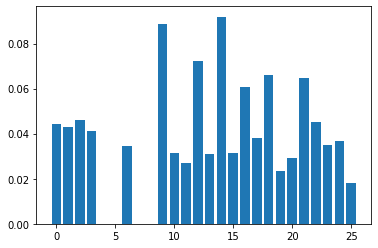

In [18]:
indices = np.argsort(model.feature_importances_)[::-1]

column_list = df.columns.tolist()
print("Feature ranking:")
for f in range(X.shape[1]-1):
    print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], model.feature_importances_[indices[f]]))

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [19]:
df.tail(10)

,Volume,Momentum,Range,Oc_diff,Varop_Spy,Varhl_spy,RSI,70 - RSI,RSI - 30,BBD_Delta_Up,...,Stoc_Slowk,Stoc_Slowd,var_bollup_kchigh,var_bolllow_kclow,Aroon Up,Aroon Down,Delta Aroon,Target,Pred,%
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-26,-155600.0,-5.414370e+07,18.680054,-17.019897,-17.019897,18.680054,58.884825,11.115175,28.884825,36.227345,...,83.352299,63.371144,-21.263177,1.169417,100.000000,33.333333,66.666667,-21.570068,-2.853830,86.769489
2019-11-27,-1102200.0,-5.297829e+07,27.189941,-17.510010,-17.510010,27.189941,63.456007,6.543993,33.456007,53.815090,...,95.298185,79.587401,-2.421523,-13.629124,100.000000,22.222222,77.777778,17.709961,-4.565149,125.777297
2019-11-29,2002200.0,3.265929e+07,23.899902,16.979980,16.979980,23.899902,57.776289,12.223711,27.776289,56.052211,...,89.334378,89.328287,3.759848,-12.004293,100.000000,11.111111,88.888889,19.200073,-0.519078,102.703521
2019-12-02,-544700.0,8.950387e+07,42.869995,22.800049,22.800049,42.869995,52.309815,17.690185,22.309815,55.218262,...,69.276786,84.636450,1.595417,-4.986854,88.888889,0.000000,88.888889,11.640015,1.355103,88.358238
2019-12-03,-710800.0,-3.367363e+07,25.640015,-9.959961,-9.959961,25.640015,49.266515,20.733485,19.266515,53.555579,...,47.845793,68.818986,0.540824,0.646490,77.777778,22.222222,55.555556,9.270020,-1.420227,115.320650
2019-12-04,153700.0,3.556591e+07,28.869995,13.320068,13.320068,28.869995,46.925099,23.074901,16.925099,50.724131,...,28.804312,48.642297,0.208774,6.803652,66.666667,11.111111,55.555556,20.209961,-2.111546,110.448046
2019-12-05,293600.0,6.500393e+07,23.500000,23.020020,23.020020,23.500000,42.214678,27.785322,12.214678,48.734163,...,15.762529,30.804211,2.597992,11.768492,55.555556,0.000000,55.555556,-11.119995,1.643535,114.780001
2019-12-06,-674600.0,-1.247036e+06,14.270020,-0.400024,-0.400024,14.270020,45.458842,24.541158,15.458842,47.199338,...,11.879928,18.815589,5.882172,13.166447,44.444444,0.000000,44.444444,2.089966,-2.422970,215.933455
2019-12-09,71500.0,2.809280e+06,21.280029,1.150024,1.150024,21.280029,44.948083,25.051917,14.948083,50.332749,...,12.545243,13.395900,8.866437,8.227608,33.333333,77.777778,-44.444444,10.300049,1.534836,85.098752


In [28]:
'''%%time
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
# load the iris datasets
# create a base classifier used to evaluate a subset of attributes
# create the RFE model and select 3 attributes
rfe = RFE(model, 5)
rfe = rfe.fit(Xtrain, ytrain)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)'''

'%%time\n# Recursive Feature Elimination\nfrom sklearn import datasets\nfrom sklearn.feature_selection import RFE\n# load the iris datasets\n# create a base classifier used to evaluate a subset of attributes\n# create the RFE model and select 3 attributes\nrfe = RFE(model, 5)\nrfe = rfe.fit(Xtrain, ytrain)\n# summarize the selection of the attributes\nprint(rfe.support_)\nprint(rfe.ranking_)'

In [30]:
%%time
tmps55=time.time()
ytrain_pred = model.predict(Xtrain)

y_pred = model.predict(Xtest)

pred = model.predict(X.iloc[:,:-1])

df['Pred'] = pred
df['%'] = (df['Target']-df['Pred'])*100/df['Target']
df.to_csv(LeChemin+'TEST_BOOST/'+symbol+'.csv')
tmps22=round(time.time()-tmps55,2)
print(Fore.BLUE,"Time for completing Generation = %f" %tmps22,'seconds \n',Style.RESET_ALL)

 Time for completing Generation = 0.070000 seconds 
 
CPU times: user 62.5 ms, sys: 5.17 ms, total: 67.7 ms
Wall time: 66.9 ms


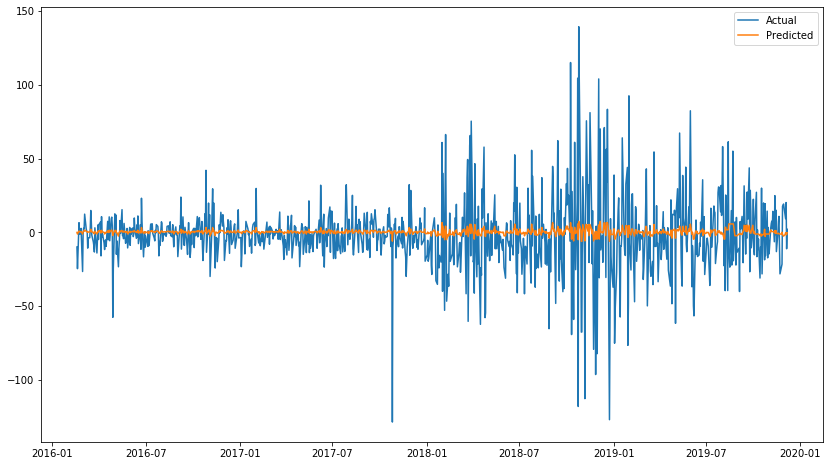

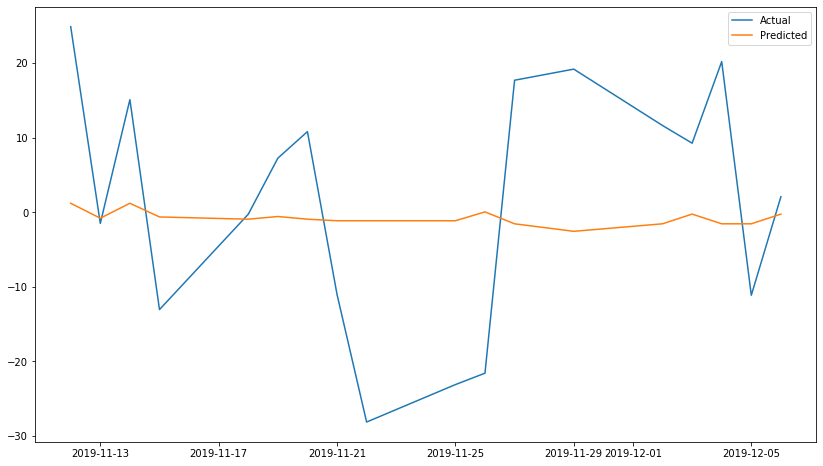

In [31]:
plt.figure(figsize=(14,8))
plt.plot(df['Target'][:-2],label='Actual')
plt.plot(df['Pred'][:-2],label='Predicted')
plt.legend()

plt.figure(figsize=(14,8))
plt.plot(df['Target'][-20:-2],label='Actual')
plt.plot(df['Pred'][-20:-2],label='Predicted')
plt.legend()

In [32]:
Xvalid = df.iloc[-2:,:-3]

(model.predict(Xvalid)-df['Target'][-2])*100/df['Target'][-2]

array([-97.656334, -97.656334], dtype=float32)

In [34]:
print(r2_score(ytest, model.predict(Xtest)))

0.000133228761072135


In [ ]:
%%time
tmps55=time.time()
print(Fore.YELLOW,'ON GENERE LES BOOST',Style.RESET_ALL)

tempo = df.copy()
#for symbol in NEW_LIST:
symbol = 'AMZN'
FUTUR = []
SYMBOL = []
PRED = []
MOMENTUM = []
df1 = pd.DataFrame()
df1['Close à trouver'] = df.iloc[-800:]['Target']
i = 0
for momentum in TIME_LIST[-800:]:
    
    long = len(TIME_LIST[-800:])
    
    i+=1
    if i == 1:
        print('\r',Fore.GREEN,' |==',Fore.BLUE,'O',Fore.RED,'==================|',end='',flush=True)
    if i == round(1 * long / 9):
        print('\r',Fore.GREEN,' |====',Fore.BLUE,'O',Fore.RED,'================|',end='',flush=True)
    if i == round(2 * long / 9):
        print('\r',Fore.GREEN,' |======',Fore.BLUE,'O',Fore.RED,'==============|',end='',flush=True)
    if i == round(3 * long / 9):
        print('\r',Fore.GREEN,' |========',Fore.BLUE,'O',Fore.RED,'============|',end='',flush=True)
    if i == round(4 * long / 9):
        print('\r',Fore.GREEN,' |==========',Fore.BLUE,'O',Fore.RED,'==========|',end='',flush=True)
    if i == round(5 * long / 9):
        print('\r',Fore.GREEN,' |============',Fore.BLUE,'O',Fore.RED,'========|',end='',flush=True)
    if i == round(6 * long / 9):
        print('\r',Fore.GREEN,' |==============',Fore.BLUE,'O',Fore.RED,'======|',end='',flush=True)
    if i == round(7 * long / 9):
        print('\r',Fore.GREEN,' |================',Fore.BLUE,'O',Fore.RED,'====|',end='',flush=True)
    if i == round(8 * long / 9):
        print('\r',Fore.GREEN,' |==================',Fore.BLUE,'O',Fore.RED,'==|',Style.RESET_ALL,end='',flush=True)
    
    #df = LaBase[LaBase['Symbol'] == symbol]
    #df = df.drop(['Symbol'],axis=1)
    df = tempo.copy()
    df = df[df.index<=momentum]
    df = df.dropna()
    seed = 770
    np.random.seed(seed)
    X = df.copy()
    y = X.iloc[:,-1]
    Xtrain = X.iloc[:-2,:-1]
    Xtest = X.iloc[-2:-1,:-1]
    ytrain = y.iloc[:-2]
    ytest = y.iloc[-2:-1]

    model = xgb.XGBRegressor(n_estimators=20000, learning_rate=1, gamma=1, subsample=1, colsample_bytree=1, max_depth=100,objective='reg:squarederror')

    model.fit( Xtrain, ytrain, early_stopping_rounds=150, eval_set=[(Xtest, ytest)], verbose=0)

    ytrain_pred = model.predict(Xtrain)

    y_pred = model.predict(Xtest)

    pred = model.predict(X.iloc[:,:-1])

    try:
        PRED.append(pred[0])
    except:
        PRED.append(9999)
    try:
        SYMBOL.append(symbol)
    except:
        SYMBOL.append('OOPS!')
    try:
        MOMENTUM.append(momentum)
    except:
        MOMENTUM.append(9999)
    #df = df.dropna()
df1['Date'] = MOMENTUM
df1['Ticker'] = SYMBOL

df1['Pred'] = PRED
df1['%'] = (df1['Close à trouver']-df1['Pred'])*100/df1['Close à trouver']
df1.to_csv(LeChemin+'TEST_BOOST/'+symbol+'.csv')
tmps22=round(time.time()-tmps55,2)
print(Fore.BLUE,"Time for completing Generation = %f" %tmps22,'seconds \n',Style.RESET_ALL)

In [ ]:
Xtest

In [ ]:
df.tail()

In [ ]:
len(PRED),len(df['Close']),len(SYMBOL),len(FUTUR),len(df['%Futur']),momentum,len(X),len(y),len(Xtrain),len(ytrain),len(Xtest),len(ytest),i,long,round(8 * long / 9),i

In [ ]:
len(df1) , len(df['%Futur']),df.iloc[-800:]['%Futur'].shape,long

In [ ]:
df.iloc[-1]['Close'].shift(-1)